In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from collections import Counter
from tensorflow.keras import Sequential
import importlib.util
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D,MaxPool2D,Softmax,Flatten
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers, models, callbacks, utils,optimizers


2025-05-03 21:41:38.480968: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746308498.662064      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746308498.714089      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## **Load Data & Exploration & Augmentation**

In [2]:
Data=ImageDataGenerator()
df=Data.flow_from_directory('/kaggle/input/german-traffic-sign-recognition-benchmark')

Found 51839 images belonging to 3 classes.


In [3]:
df.class_indices

{'test': 0, 'train': 1, 'val': 2}

In [4]:
def to_float32(img):
    return img.astype(np.float32)
trainD=ImageDataGenerator(
rescale=1./255,rotation_range=15,
    preprocessing_function=to_float32,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)        # Fill edges with reflection (better than black))
df_train=trainD.flow_from_directory('/kaggle/input/german-traffic-sign-recognition-benchmark/train',target_size=(32,32),batch_size=32,class_mode='categorical')


Found 35288 images belonging to 43 classes.


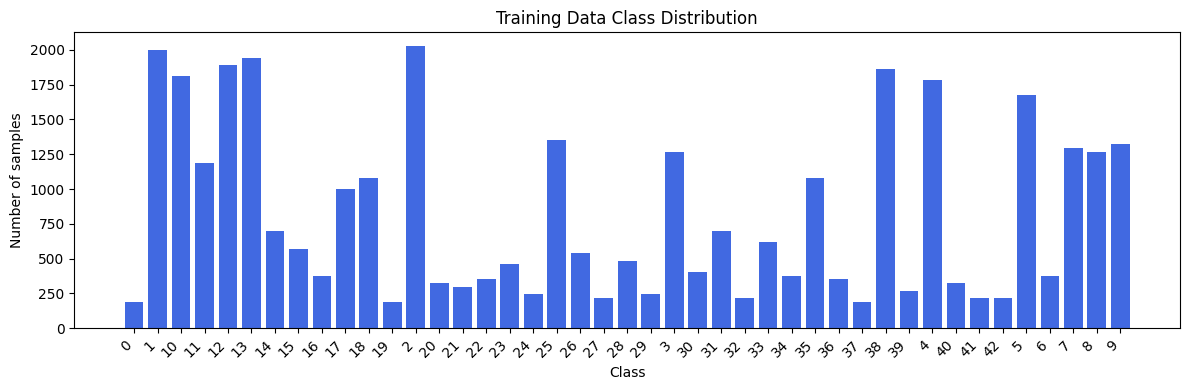

In [5]:
from collections import Counter
import matplotlib.pyplot as plt

counts = Counter(df_train.classes)
labels = list(df_train.class_indices.keys())
values = [counts[df_train.class_indices[label]] for label in labels]

plt.figure(figsize=(12,4))
bars = plt.bar(x=labels, height=values, color='royalblue')  # Changed to 'color' parameter
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Training Data Class Distribution')

# Optional: Rotate x-axis labels if they're long
plt.xticks(rotation=45, ha='right')

plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

In [6]:
testD=ImageDataGenerator(rescale=1./255,preprocessing_function=to_float32)
df_test=testD.flow_from_directory('/kaggle/input/german-traffic-sign-recognition-benchmark/test',target_size=(32,32),batch_size=32,class_mode='categorical')

Found 12630 images belonging to 43 classes.


In [7]:
valtD=ImageDataGenerator(rescale=1./255,preprocessing_function=to_float32)
df_val=valtD.flow_from_directory('/kaggle/input/german-traffic-sign-recognition-benchmark/val',target_size=(32,32),batch_size=32,class_mode='categorical')

Found 3921 images belonging to 43 classes.


## **Model Architecture & Prepare Optmizers**

In [8]:
def create_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        # four hidden layers: 512, 128, 32, 10 nodes
        layers.Dense(512, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(32, activation='relu'),
        # output layer: 10 nodes, softmax
        layers.Dense(43, activation='softmax')
    ])
    return model



In [9]:
model=create_cnn()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1746308571.799830      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 10, 10, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         819,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 43)                  │           1,419 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 956,491 (3.65 MB)

 Trainable params: 956,491 (3.65 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
import pickle
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Set your custom learning rate
learning_rate = 0.001

# Define early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

print("\nTraining with Adam...")
model = create_cnn()  # Define your model elsewhere

model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model with early stopping
history = model.fit(
    df_train,
    epochs=10,
    validation_data=df_val,
    callbacks=[early_stop],
    verbose=1
)

# Save model
model.save("model_trained.h5")

# Save training history to a pickle file
with open("training_history.pkl", "wb") as f:
    pickle.dump(history.history, f)



Training with Adam...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1746308577.384213     120 service.cc:148] XLA service 0x7ea32000e5a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746308577.384917     120 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746308577.783825     120 cuda_dnn.cc:529] Loaded cuDNN version 90300


   3/1103 ━━━━━━━━━━━━━━━━━━━━ 59s 54ms/step - accuracy: 0.0069 - loss: 3.7569      

I0000 00:00:1746308580.040120     120 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1103/1103 ━━━━━━━━━━━━━━━━━━━━ 131s 113ms/step - accuracy: 0.2643 - loss: 2.5799 - val_accuracy: 0.7212 - val_loss: 0.7471
Epoch 2/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 56s 50ms/step - accuracy: 0.7227 - loss: 0.7994 - val_accuracy: 0.8758 - val_loss: 0.3572
Epoch 3/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 53s 47ms/step - accuracy: 0.8618 - loss: 0.4036 - val_accuracy: 0.9357 - val_loss: 0.1926
Epoch 4/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 52s 47ms/step - accuracy: 0.9108 - loss: 0.2621 - val_accuracy: 0.9518 - val_loss: 0.1416
Epoch 5/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 52s 47ms/step - accuracy: 0.9306 - loss: 0.2050 - val_accuracy: 0.9648 - val_loss: 0.1019
Epoch 6/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 54s 48ms/step - accuracy: 0.9387 - loss: 0.1787 - val_accuracy: 0.9577 - val_loss: 0.1223
Epoch 7/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 51s 46ms/step - accuracy: 0.9471 - loss: 0.1560 - val_accuracy: 0.9605 - val_loss: 0.1183
Epoch 8/10
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 52s 47ms/step - accuracy: 0.9528 - loss: 0.

## **plotting Evaluations**

In [14]:
model.save("model_trained.h5")

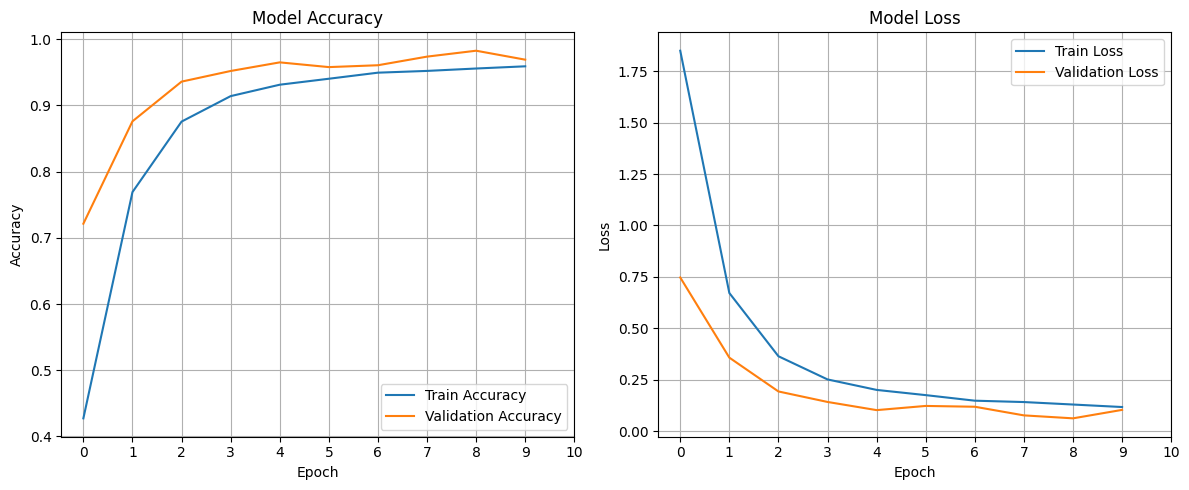

In [15]:
import pickle
import matplotlib.pyplot as plt

with open("/kaggle/working/training_history.pkl", "rb") as f:
    hist = pickle.load(f)

epochs = range(len(hist['accuracy']))
custom_ticks = list(range(0, len(epochs)+1, 1))  # Every 3 epochs

# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, hist['accuracy'], label='Train Accuracy')
plt.plot(epochs, hist['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(custom_ticks)
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, hist['loss'], label='Train Loss')
plt.plot(epochs, hist['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(custom_ticks)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [13]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(df_test, verbose=0)

print(f"Test Accuracy: {test_accuracy * 100:.1f}%")


Test Accuracy: 92.8%
